# This project investigates using a Convolutional Neural Network (CNN) to detect pneumonia in chest X-rays. We leverage a dataset of X pediatric chest X-rays (1-5 years old) categorized as Normal or Pneumonia (train/val/test split).

In [ ]:
# Import Necessary library

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import zipfile

from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extracting ZipFolder
zip_folder = zipfile.ZipFile('/content/drive/MyDrive/Detecting Pneumonia in Chest X-rays /modified_chest_xray-20240507T075354Z-001.zip','r')
zip_folder.extractall()
zip_folder.close()

In [ ]:
# Defining File Path
test_path = '/content/modified_chest_xray/test_df'
train_path = '/content/modified_chest_xray/train_df'

In [ ]:
# Creating Class-Names & Extracting images
classes = os.listdir(test_path)
train_images_list = [os.listdir(os.path.join(train_path,i)) for i in classes]
len(train_images_list)

2

In [ ]:
# Sampling
import random
sample_img = [random.sample(files,1) for files in train_images_list ]
sample_img

[['NORMAL2-IM-1025-0001.jpeg'], ['person540_bacteria_2271.jpeg']]

In [ ]:
read_img = [ Image.open(os.path.join(train_path,cls,i[0])) for i,cls in zip(sample_img,classes)]

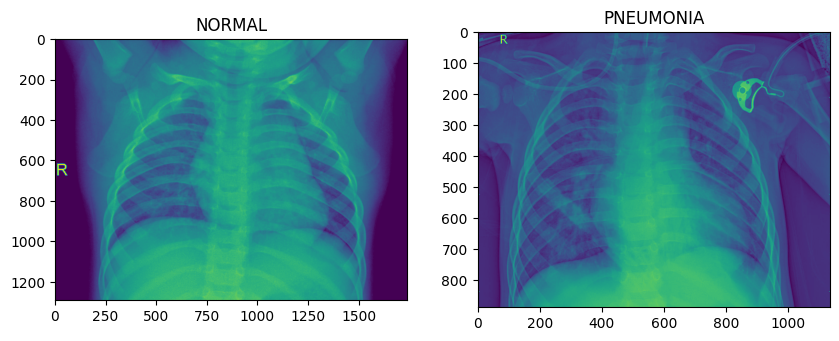

In [ ]:
# Visualizing Images
fig, axe = plt.subplots(1,2, figsize=(10,10))
axe = axe.flatten()
for i,j in enumerate(read_img):
  axe[i].imshow(j)
  axe[i].set_title(classes[i])
plt.show()

In [ ]:
# Creating Image Batches
train_dir = keras.preprocessing.image_dataset_from_directory(train_path,
                                                             label_mode = 'binary',
                                                             batch_size = 32,
                                                             image_size = (224,224))

test_dir = keras.preprocessing.image_dataset_from_directory(test_path,
                                                            label_mode = "binary",
                                                            batch_size = 32,
                                                            image_size = (224,224))

Found 1000 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
# Creating Instance of Data-Augmentation
train_augmented = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomRotation(20),
    keras.layers.RandomHeight(0.2),
    keras.layers.RandomWidth(0.2)
    ])

In [ ]:
# Creating Callbacks-checkpoint
callback_path = "model_checkpoint/checkpoint.ckpt"
callback = keras.callbacks.ModelCheckpoint(filepath = callback_path,
                                           save_weights_only=True,
                                           save_best_only = False,
                                           save_freq = "epoch")

In [ ]:
# Creating Base-Model
base_model = keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = train_augmented(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1,activation = "sigmoid")(x)

model_1 = keras.Model(inputs,outputs)

# Fine-tuning BaseModel
base_model.trainable = True
layers = base_model.layers
for layer in layers[:-150]:
  layer.trainable = False

# Compiling The Model
model_1.compile(loss="binary_crossentropy",
                optimizer = keras.optimizers.Adam(lr = 0.01),
                metrics = ['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Training The Model with Test Data
history_1 = model_1.fit(train_dir,
                        epochs = 5,
                        steps_per_epoch=len(train_dir),
                        validation_data = test_dir,
                        validation_steps = len(test_dir),
                        callbacks = [callback])

Epoch 1/5
32/32 [==============================] - 45s 566ms/step - loss: 0.7666 - accuracy: 0.6320 - val_loss: 0.8100 - val_accuracy: 0.7067
Epoch 2/5
32/32 [==============================] - 20s 582ms/step - loss: 0.8693 - accuracy: 0.5550 - val_loss: 0.8054 - val_accuracy: 0.6250
Epoch 3/5
32/32 [==============================] - 17s 490ms/step - loss: 0.6606 - accuracy: 0.5990 - val_loss: 0.6244 - val_accuracy: 0.6250
Epoch 4/5
32/32 [==============================] - 19s 533ms/step - loss: 0.4780 - accuracy: 0.8000 - val_loss: 0.8786 - val_accuracy: 0.6923
Epoch 5/5
32/32 [==============================] - 20s 548ms/step - loss: 1.0070 - accuracy: 0.6500 - val_loss: 0.5789 - val_accuracy: 0.7628


<Axes: >

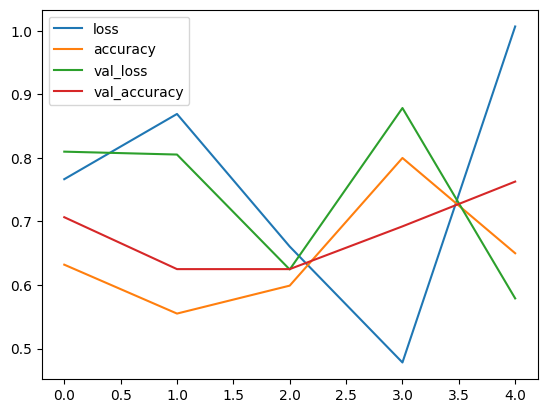

In [ ]:
# Plotting Accuracy-loss Curves
pd.DataFrame(history_1.history).plot()

In [ ]:
# Training model for more epochs
history_2 = model_1.fit(train_dir,
                        epochs = 10,
                        steps_per_epoch=len(train_dir),
                        validation_data = test_dir,
                        validation_steps = len(test_dir),
                        callbacks = [callback],
                        initial_epoch = history_1.epoch[-1])

Epoch 5/10
32/32 [==============================] - 18s 539ms/step - loss: 0.5370 - accuracy: 0.7590 - val_loss: 0.6052 - val_accuracy: 0.8173
Epoch 6/10
32/32 [==============================] - 20s 578ms/step - loss: 0.4295 - accuracy: 0.8230 - val_loss: 0.5069 - val_accuracy: 0.7949
Epoch 7/10
32/32 [==============================] - 18s 512ms/step - loss: 0.4574 - accuracy: 0.8410 - val_loss: 0.6220 - val_accuracy: 0.7003
Epoch 8/10
32/32 [==============================] - 18s 520ms/step - loss: 0.2712 - accuracy: 0.9030 - val_loss: 0.2893 - val_accuracy: 0.8686
Epoch 9/10
32/32 [==============================] - 17s 502ms/step - loss: 0.2246 - accuracy: 0.9250 - val_loss: 0.2646 - val_accuracy: 0.8926
Epoch 10/10
32/32 [==============================] - 18s 521ms/step - loss: 0.2491 - accuracy: 0.9190 - val_loss: 0.2645 - val_accuracy: 0.8862


<Axes: >

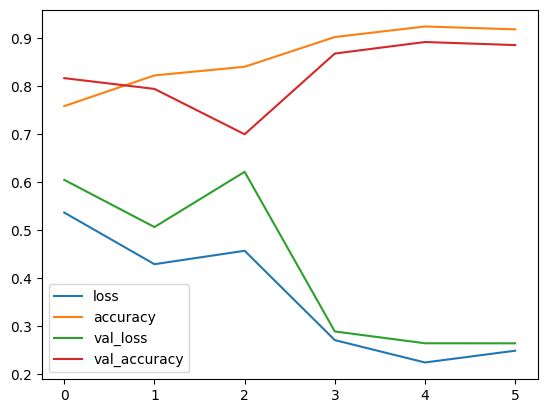

In [ ]:
# Plotting Accuracy-loss Curves
pd.DataFrame(history_2.history).plot()

In [ ]:
# Training Model For More Epochs
history_3 = model_1.fit(train_dir,
                        epochs = 25,
                        steps_per_epoch=len(train_dir),
                        validation_data = test_dir,
                        validation_steps = len(test_dir),
                        callbacks = [callback],
                        initial_epoch = history_2.epoch[-1])

Epoch 10/25
32/32 [==============================] - 19s 543ms/step - loss: 0.2046 - accuracy: 0.9170 - val_loss: 0.2224 - val_accuracy: 0.9119
Epoch 11/25
32/32 [==============================] - 17s 499ms/step - loss: 0.1913 - accuracy: 0.9360 - val_loss: 0.2259 - val_accuracy: 0.9006
Epoch 12/25
32/32 [==============================] - 17s 492ms/step - loss: 0.1753 - accuracy: 0.9440 - val_loss: 0.3886 - val_accuracy: 0.8526
Epoch 13/25
32/32 [==============================] - 19s 547ms/step - loss: 0.1543 - accuracy: 0.9530 - val_loss: 0.1892 - val_accuracy: 0.9279
Epoch 14/25
32/32 [==============================] - 18s 540ms/step - loss: 0.1568 - accuracy: 0.9470 - val_loss: 0.2363 - val_accuracy: 0.8814
Epoch 15/25
32/32 [==============================] - 18s 494ms/step - loss: 0.1392 - accuracy: 0.9470 - val_loss: 0.1888 - val_accuracy: 0.9263
Epoch 16/25
32/32 [==============================] - 16s 470ms/step - loss: 0.1777 - accuracy: 0.9340 - val_loss: 0.1701 - val_accuracy:

<Axes: >

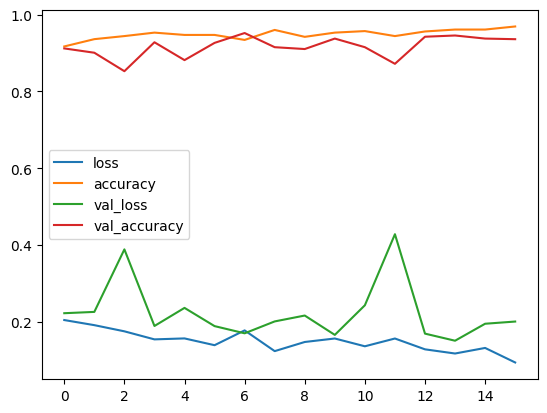

In [ ]:
# Plotting Accuracy-loss Curves
pd.DataFrame(history_3.history).plot()

In [ ]:
# Saved Our Best Model
model_1.save('t96_ts93_pn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Importing our Best Model
loaded_model = keras.models.load_model("/content/drive/MyDrive/Detecting Pneumonia in Chest X-rays /t96_ts93_pn_model.h5")

In [ ]:
# Extract true labels (assuming class folders within test_data_dir)
test_data_dir = test_path
true_labels = []
predicted_labels = []

for class_name in os.listdir(test_data_dir):
    if class_name not in ['NORMAL', 'PNEUMONIA']:  # Skip non-class folders (if any)
        continue
    true_labels.extend([class_name] * len(os.listdir(os.path.join(test_data_dir, class_name))))

true_labels = [ 0 if i == "NORMAL" else 1 for i in true_labels]

In [ ]:
# Predict on test data (replace with your prediction logic)
import cv2 as cv
test_data_dir = test_path
predicted_labels =[]
for image_path in os.listdir(test_data_dir):
  for img_name in os.listdir(os.path.join(test_path,image_path)):
    image = cv.imread(os.path.join(test_path,image_path,img_name))# Replace with image loading logic (e.g., using PIL)
    image = cv.resize(image,(224,224))
    image = image.reshape((1,224,224,3))
    pred = loaded_model.predict(image,verbose=0)
    predicted_labels.append(np.round(pred.squeeze().tolist()))

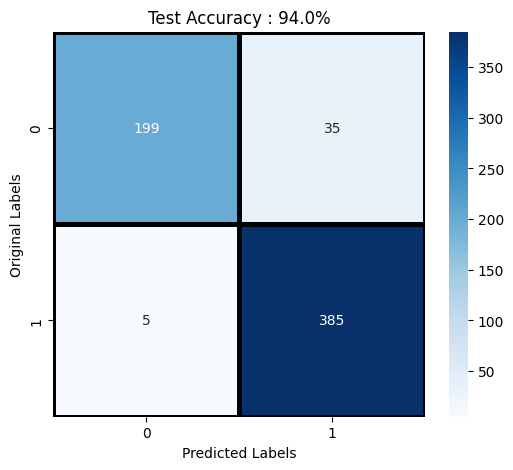

In [ ]:
# Visualizing Accuracy by Confusion Matrix
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

cm = confusion_matrix(true_labels,predicted_labels)
accuracy = np.round(accuracy_score(true_labels,predicted_labels),2)*100
plt.figure(figsize= (6,5))
sns.heatmap(cm, annot=True,fmt ='d', cmap='Blues', cbar=True,linewidths=2.5,linecolor="black")
plt.title(f"Test Accuracy : {accuracy}%")
plt.xlabel('Predicted Labels')
plt.ylabel('Original Labels')
plt.show()

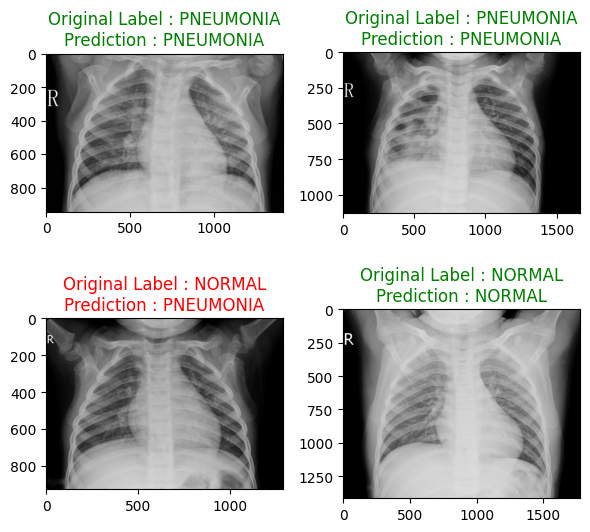

In [ ]:
# Testing Model on Validation Random Images
import random
import cv2 as cv
val_path = '/content/modified_chest_xray/val'
class_name = ['NORMAL','PNEUMONIA']
sample = [ random.sample(os.listdir(os.path.join(val_path,cls)),2) for cls in classes ]
a=0
figs, axe = plt.subplots(2,2,figsize=(6,6))
ax = axe.flatten()
for list_img,cls in zip(sample,classes):
  for img in list_img:
    img = cv.imread(os.path.join(val_path,cls,img))
    if img is not None:
      read_img = cv.resize(img,(224,224))
      read_img = read_img.reshape((1,224,224,3))
      pred = loaded_model.predict(read_img,verbose=0)
      ans = class_name[int(np.round(pred.squeeze()))]
      ax[a].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
      if ans == cls:
        ax[a].set_title(f"Original Label : {cls}\nPrediction : {ans}",color = "green")
      else:
        ax[a].set_title(f"Original Label : {cls}\nPrediction : {ans}",color = "red")
      a+=1
      plt.tight_layout()

plt.show()